# Environment setup

# Import neccessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [ ]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

# Data processing

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.RandomRotation(5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=r'D:\Lab\Organization\OctoOpt\DemOpt\dataset', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=r'D:\Lab\Organization\OctoOpt\DemOpt\dataset', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 31492052.51it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


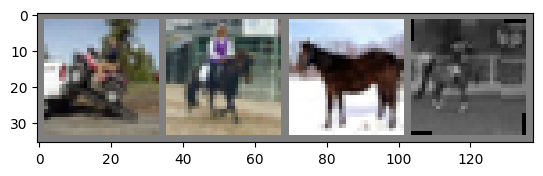

truck horse horse horse


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Model architecture

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
net = Classifier()
net

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Experiemnts

1. 'SGD',
2. 'Adam',
3. 'RMSprop',
4. 'Adadelta',
5. 'Adagrad'

## Optimizers

In [8]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad)

In [ ]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad)
            param.sub_(self.lr * v)

In [ ]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [ ]:
class Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))

In [ ]:
class RMSprop:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [ ]:
class RMSpropAlt:
    def __init__(self, model_params, lr=1e-2, alpha=0.99, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_sqr_grads = [torch.ones_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad in zip(self.model_params, self.avg_sqr_grads):
            avg_sqr_grad.mul_(self.alpha).add_(param.grad * param.grad * (1 - self.alpha))
            std = avg_sqr_grad.add(self.eps).sqrt()
            param.sub_((self.lr / std) * param.grad)

In [ ]:
class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.avg_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.n_steps = 0

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_grad, avg_sqr_grad in zip(self.model_params, \
                                                 self.avg_grads, \
                                                 self.avg_sqr_grads):
            self.n_steps += 1
            avg_grad.mul_(self.beta_1).add_(param.grad * (1 - self.beta_1))
            avg_sqr_grad.mul_(self.beta_2).add_(param.grad * param.grad * (1 - self.beta_2))
            avg_grad_corrected = avg_grad.div(1 - self.beta_1 ** self.n_steps)
            avg_sqr_grad_corrected = avg_sqr_grad.div(1 - self.beta_2 ** self.n_steps)
            std = avg_sqr_grad_corrected.sqrt().add(self.eps)
            param.sub_(self.lr * avg_grad_corrected / std)

## Training and Validating
+ Record all losses and time from each epoch that the model trained.

In [9]:
net = Classifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(net.parameters(), lr=0.001)

In [12]:
class Trainer:
  def __init__(self, model, loss_fn, optimizer):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.log = {
        'train_losses': [],
        'val_losses': [],
        'timer': []
    }

  def _train_per_epoch(self, epoch_index, training_dataloader):
    self.model.train()
    running_loss = 0.
    last_loss = 0.

    for i, data in tqdm(enumerate(training_dataloader),
                        desc=f'Training at epoch {epoch_index}'):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      self.optimizer.zero_grad()                # Compute the loss and its gradients
      outputs = self.model(inputs)
      loss = self.loss_fn(outputs, labels)
      loss.backward()                           # Compute the loss and its gradients
      self.optimizer.step()                     # Adjust learning weights

      running_loss += loss.item()
      if i % 1000 == 999:
        last_loss = running_loss / 1000.0
        print(f'Batch {epoch_index+1} loss {last_loss}')
        self.log['train_losses'].append(last_loss)
        running_loss = 0.

    return last_loss

  def _eval_per_epoch(self, epoch_index, val_dataloader):
    self.model.eval()
    running_vloss = 0.
    with torch.no_grad():
      for i, data in tqdm(enumerate(val_dataloader),
                          desc=f'Validating at epoch {epoch_index}'):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, labels)
        running_vloss += loss

        self.log['val_losses'].append(running_vloss)
    avg_vloss = running_vloss / (i + 1)
    return  avg_vloss

  def fit(self, epochs, training_dataloader, val_dataloader):
    if val_dataloader == None:
      print('No validation during experiment')

    for epoch in range(epochs):
      avg_loss = self._train_per_epoch(epoch, training_dataloader)

      if val_dataloader:
        avg_vloss = self._eval_per_epoch(epoch, val_dataloader)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

In [ ]:
net = Classifier().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = SGD(net.parameters(), lr=0.001)

trainer_sgd = Trainer(net, loss_fn, optimizer)
trainer_sgd.fit(epochs=100,
                training_dataloader=trainloader,
                val_dataloader=testloader)

# Inference

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Classifier()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')